In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf

%matplotlib inline

In [2]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
print(model)

{'input': <tf.Variable 'Variable:0' shape=(1, 300, 400, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0' shap

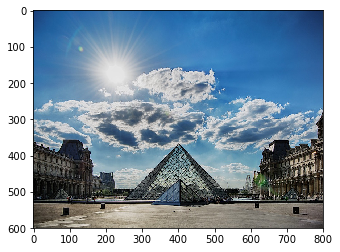

In [3]:
content_image = scipy.misc.imread("images/louvre.jpg")
imshow(content_image)

In [4]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
   
    a_C_unrolled = tf.reshape(a_C,[n_C,n_H*n_W])
    a_G_unrolled = tf.reshape(a_G,[n_C,n_H*n_W])
    
   
    J_content = (tf.reduce_sum(tf.square(tf.subtract(a_C,a_G))))/(4*n_H*n_W*n_C)

    return J_content

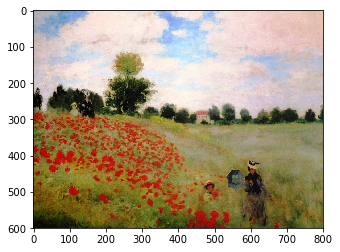

In [6]:
style_image = scipy.misc.imread("images/monet_800600.jpg")
imshow(style_image)

In [7]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """

    GA = tf.matmul(A,tf.transpose(A))

    return GA

In [9]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.reshape(a_S,(n_H*n_W,n_C))
    a_G = tf.reshape(a_G,(n_H*n_W,n_C))

   
    GS = gram_matrix(tf.transpose(a_S))
    GG = gram_matrix(tf.transpose(a_G))
    

   
    J_style_layer = (tf.reduce_sum(tf.square(tf.subtract(GS,GG))))/(np.square(2*n_C*n_H*n_W))

    return J_style_layer

In [11]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [12]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    

    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        
        out = model[layer_name]

        
        a_S = sess.run(out)

        a_G = out
        
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        J_style += coeff * J_style_layer

    return J_style

In [13]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    J = alpha*J_content+beta*J_style
    
    return J

In [15]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

Let's load, reshape, and normalize our "content" image (the Louvre museum picture):

In [16]:
content_image = scipy.misc.imread("images/louvre_small.jpg")
content_image = reshape_and_normalize_image(content_image)

Let's load, reshape and normalize our "style" image (Claude Monet's painting):

In [17]:
style_image = scipy.misc.imread("images/monet.jpg")
style_image = reshape_and_normalize_image(style_image)

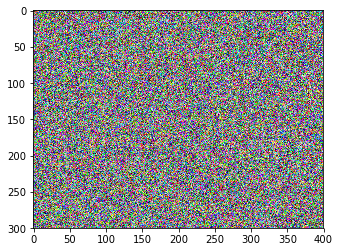

In [18]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

In [19]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

In [20]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

In [21]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [22]:
### START CODE HERE ### (1 line)
J = total_cost(J_content, J_style, alpha = 10, beta = 40)
### END CODE HERE ###

In [23]:
# define optimizer (1 line)
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step (1 line)
train_step = optimizer.minimize(J)

In [25]:
def model_nn(sess, input_image, num_iterations = 200):
    
    
    init = tf.global_variables_initializer()
    sess.run(init)
    
    
    sess.run(model['input'].assign(input_image))
 
    
    for i in range(num_iterations):
    
        sess.run(train_step)
       
        
        generated_image = sess.run(model['input'])

   
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            
            save_image("output/" + str(i) + ".png", generated_image)
    
  
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [26]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 5.05035e+09
content cost = 7877.67
style cost = 1.26257e+08
Iteration 20 :
total cost = 9.43276e+08
content cost = 15186.9
style cost = 2.35781e+07
Iteration 40 :
total cost = 4.84898e+08
content cost = 16785.0
style cost = 1.21183e+07
Iteration 60 :
total cost = 3.12574e+08
content cost = 17465.8
style cost = 7.80998e+06
Iteration 80 :
total cost = 2.28137e+08
content cost = 17715.0
style cost = 5.699e+06
Iteration 100 :
total cost = 1.80694e+08
content cost = 17895.4
style cost = 4.51288e+06
Iteration 120 :
total cost = 1.49996e+08
content cost = 18034.3
style cost = 3.74539e+06
Iteration 140 :
total cost = 1.27698e+08
content cost = 18186.8
style cost = 3.18791e+06
Iteration 160 :
total cost = 1.10698e+08
content cost = 18354.2
style cost = 2.76287e+06
Iteration 180 :
total cost = 9.73408e+07
content cost = 18500.9
style cost = 2.4289e+06


array([[[[ -47.57871246,  -61.58271027,   48.85700226],
         [ -26.18411827,  -40.68395233,   26.88046837],
         [ -41.80831909,  -29.10873032,   11.2266655 ],
         ..., 
         [ -26.84453201,   -9.60996437,   14.25239944],
         [ -30.21216583,   -2.98944783,   24.00558853],
         [ -42.19843674,   -4.09546566,   49.32817459]],

        [[ -61.05371094,  -51.83226395,   25.20266914],
         [ -33.09142303,  -31.14856339,   -1.57329547],
         [ -27.17674255,  -30.73937416,   15.13497353],
         ..., 
         [ -26.78427505,   -5.31921244,   25.96679497],
         [ -21.39604187,  -17.04573441,   13.87594414],
         [ -40.57749176,   -6.21540785,    9.49932194]],

        [[ -52.21483612,  -51.62369156,   13.53674698],
         [ -37.20645905,  -41.47898865,   -6.33634949],
         [ -34.18973541,  -25.27192116,    7.34102583],
         ..., 
         [ -10.66579914,  -37.37947845,   12.56488609],
         [ -12.27160835,  -21.02189064,   17.14487648],

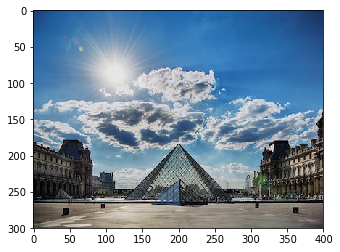

In [3]:
c_image = scipy.misc.imread("images/louvre_small.jpg")
imshow(c_image)

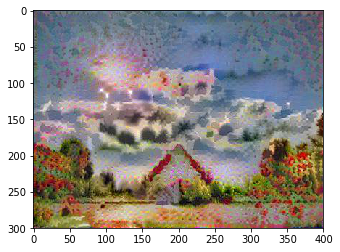

In [2]:
g_n = scipy.misc.imread("output/generated_image.jpg")
imshow(g_n)



<img src="images/louvre_generated.png" style="width:800px;height:300px;">
